# ResNet

给定输入边长$N$，卷积核大小$K$，填充大小$P$，和步长$S$，单侧边长的输出大小$O$（不考虑批次大小和深度）可以通过下面的公式计算：
$$ O = \frac{N - K + 2P}{S} + 1 $$

![](./images/resnet.png)

## with pytorch

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.optim import lr_scheduler
from torchvision import datasets, transforms

### 定义网络

#### 1, 实线部分

![](./images/resnet_1.jpg)

In [5]:
class basic_block(nn.Module):
    '''定义了带实线部分的残差块，输入和输出通道数和形状相同'''
    def __init__(self,in_channels):
        super(basic_block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(in_channels,in_channels,kernel_size=3,stride=1,padding=1)
        self.b1 = nn.BatchNorm2d(in_channels)
        self.b2 = nn.BatchNorm2d(in_channels)
    def forward(self, x):
        y = F.relu(self.b1(self.conv1(x)))
        y = self.b2(self.conv2(y))
        return F.relu(y+x)

class basic_block2(nn.Module):
    '''定义了带虚线部分的残差块，输入和输出通道数和形状不同'''
    def __init__(self,in_channels,out_channels):
        super(basic_block2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=2)
        self.conv2 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=2,padding=1)
        self.conv3 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1)
        self.b1 = nn.BatchNorm2d(out_channels)
        self.b2 = nn.BatchNorm2d(out_channels)
        self.b3 = nn.BatchNorm2d(out_channels)
    def forward(self, x):
        z = self.b1(self.conv1(x))
        y = F.relu(self.b2(self.conv2(x)))
        y = self.b3(self.conv3(y))
        return F.relu(y+z)

class MyResNet18(nn.Module):
    def __init__(self):
        super(MyResNet18, self).__init__()
        # 第一层：卷积层
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        # Max Pooling 层
        self.s1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 第二、三、四、五层：“实线”卷积层
        self.resn1 = basic_block(64)
        self.resn2 = basic_block(64)
        # 第六、七层：“虚线”卷积层
        self.resn3 = basic_block2(64,128)
        # 第八、九层：“实线”卷积层
        self.resn4 = basic_block(128)
        # # 第十、十一层：“虚线”卷积层
        self.resn5 = basic_block2(128,256)
        # 第十二 、十三层：“实线”卷积层
        self.resn6 = basic_block(256)
        # 第十四、十五层：“虚线”卷积层
        self.resn7 = basic_block2(256,512)
        # 第十六 、十七层：“实线”卷积层
        self.resn8 = basic_block(512)
        # avg pooling 层
        self.s2 = nn.AvgPool2d(kernel_size=7, stride=1, padding=0)
        # 第十八层：全连接层
        self.Flatten = nn.Flatten()
        self.f18 = nn.Linear(512, 1000)
        # 为满足该实例另加
        self.f_output = nn.Linear(1000, 10)

    def forward(self, x):  # shape: torch.Size([1, 3, 224, 224])
        x = self.conv1(x)  # shape: torch.Size([1, 64, 112, 112])
        x = self.bn1(x)  # shape: torch.Size([1, 64, 112, 112])
        x = self.s1(x)  # shape: torch.Size([1, 64, 56, 56])
        x = self.conv2(x)  # shape: torch.Size([1, 64, 56, 56])
        x = self.bn2(x)  # shape: torch.Size([1, 64, 56, 56])
        x = self.conv3(x)  # shape: torch.Size([1, 64, 56, 56])
        x = self.bn3(x)  # shape: torch.Size([1, 64, 56, 56])
        x = self.conv4(x)  # shape: torch.Size([1, 64, 56, 56])
        x = self.bn4(x)  # shape: torch.Size([1, 64, 56, 56])
        x = self.conv5(x)  # shape: torch.Size([1, 64, 56, 56])
        x = self.bn5(x)  # shape: torch.Size([1, 64, 56, 56])
        x6_1 = self.conv6_1(x)  # shape: torch.Size([1, 128, 28, 28])
        x7_1 = self.conv7_1(x6_1)  # shape: torch.Size([1, 128, 28, 28])
        x7 = self.conv7(x)  # shape: torch.Size([1, 128, 28, 28])
        x = x7 + x7_1  # shape: torch.Size([1, 128, 28, 28])
        x = self.conv8(x)  # shape: torch.Size([1, 128, 28, 28])
        x = self.conv9(x)  # shape: torch.Size([1, 128, 28, 28])
        x10_1 = self.conv10_1(x)  # shape: torch.Size([1, 256, 14, 14])
        x11_1 = self.conv11_1(x10_1)  # shape: torch.Size([1, 256, 14, 14])
        x11 = self.conv11(x)  # shape: torch.Size([1, 256, 14, 14])
        x = x11 + x11_1  # shape: torch.Size([1, 256, 14, 14])
        x = self.conv12(x)  # shape: torch.Size([1, 256, 14, 14])
        x = self.conv13(x)  # shape: torch.Size([1, 256, 14, 14])
        x14_1 = self.conv14_1(x)  # shape: torch.Size([1, 512, 7, 7])
        x15_1 = self.conv15_1(x14_1)  # shape: torch.Size([1, 512, 7, 7])
        x15 = self.conv15(x)  # shape: torch.Size([1, 512, 7, 7])
        x = x15 + x15_1  # shape: torch.Size([1, 512, 7, 7])
        x = self.conv16(x)  # shape: torch.Size([1, 512, 7, 7])
        x = self.conv17(x)  # shape: torch.Size([1, 512, 7, 7])
        x = self.s2(x)  # shape: torch.Size([1, 512, 1, 1])
        x = self.Flatten(x)  # shape: shape: torch.Size([1, 512])
        x = self.f18(x)  # shape: torch.Size([1, 1000])
        # 为满足该实例另加 ↓
        x = self.f_output(x)  # shape: torch.Size([1, 10])
        x = F.softmax(x, dim=1)  # shape: torch.Size([1, 10])
        return x

### 准备数据

In [ ]:
data_transform = transforms.Compose(
    [
        transforms.Resize(224),  # 缩放图像大小为 224*224
        transforms.ToTensor(),  # 仅对数据做转换为 tensor 格式操作
    ]
)

# 加载训练数据集
train_dataset = datasets.MNIST(
    root='./data', train=True, transform=data_transform, download=True
)
# 给训练集创建一个数据集加载器
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True
)
# 加载测试数据集
test_dataset = datasets.MNIST(
    root='./data', train=False, transform=data_transform, download=True
)
# 给测试集创建一个数据集加载器
test_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=8, shuffle=True
)

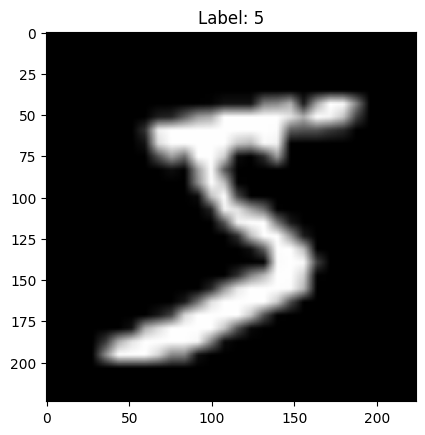

In [4]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

# `image`现在是一个[C, H, W]的Tensor，使用matplotlib展示之前，需要转换为[H, W, C]或[H, W]的格式
image = image.permute(1, 2, 0)
# 或者因为MNIST是灰度图，所以实际只需要将通道维度去掉
# image = image.squeeze()

plt.imshow(image, cmap="gray")  # 使用灰度色彩映射
plt.title(f'Label: {label}')
plt.show()

### 其他定义

In [16]:
# 如果显卡可用，则用显卡进行训练
device = "cuda" if torch.cuda.is_available() else 'cpu'

# 调用 net 里定义的模型，如果 GPU 可用则将模型转到 GPU
model = MyResNet18().to(device)

# 定义损失函数（交叉熵损失）
loss_fn = nn.CrossEntropyLoss()
# 定义优化器（SGD：随机梯度下降）
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# 学习率每隔 10 个 epoch 变为原来的 0.1
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# 定义训练函数
def train(dataloader, model, loss_fn, optimizer):
    loss, current, n = 0.0, 0.0, 0
    for batch, (X, y) in enumerate(dataloader):
        # 单通道转为三通道
        X = np.array(X)
        X = X.transpose((1, 0, 2, 3))  # array 转置
        image = np.concatenate((X, X, X), axis=0)
        image = image.transpose((1, 0, 2, 3))  # array 转置回来
        image = torch.tensor(image)  # 将 numpy 数据格式转为 tensor
        # 前向传播
        image, y = image.to(device), y.to(device)
        output = model(image)
        cur_loss = loss_fn(output, y)
        _, pred = torch.max(output, axis=1)
        cur_acc = torch.sum(y == pred) / output.shape[0]
        # 反向传播
        optimizer.zero_grad()
        cur_loss.backward()
        optimizer.step()
        loss += cur_loss.item()
        current += cur_acc.item()
        n = n + 1
    print('train_loss：' + str(loss / n))
    print('train_acc：' + str(current / n))


# 定义测试函数
def test(dataloader, model, loss_fn):
    # 将模型转换为验证模式
    model.eval()
    loss, current, n = 0.0, 0.0, 0
    # 非训练，推理期用到（测试时模型参数不用更新，所以 no_grad）
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            # 单通道转为三通道
            X = np.array(X)
            X = X.transpose((1, 0, 2, 3))  # array 转置
            image = np.concatenate((X, X, X), axis=0)
            image = image.transpose((1, 0, 2, 3))  # array 转置回来
            image = torch.tensor(image)  # 将 numpy 数据格式转为 tensor
            image, y = image.to(device), y.to(device)
            output = model(image)
            cur_loss = loss_fn(output, y)
            _, pred = torch.max(output, axis=1)
            cur_acc = torch.sum(y == pred) / output.shape[0]
            loss += cur_loss.item()
            current += cur_acc.item()
            n = n + 1
        print('test_loss：' + str(loss / n))
        print('test_acc：' + str(current / n))

### 开始训练

In [ ]:
epoch = 100
for t in range(epoch):
    lr_scheduler.step()
    print(f"Epoch {t + 1}\n----------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
    torch.save(model.state_dict(), "save_model/{}model.pth".format(t))  # 模型保存
print("Done!")

## with fastai

In [2]:
from fastai.layers import *
from fastai.vision.all import *

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 准备数据

In [3]:
path = untar_data(URLs.MNIST)
il = ImageDataLoaders.from_folder(
    path,
    train='training',
    valid='testing',
    valid_pct=0.2,
    item_tfms=Resize(224),
    bs=64,  # 设置批量大小为64
    seed=42,
)

torch.Size([64, 3, 224, 224]) torch.Size([64])


<Axes: >

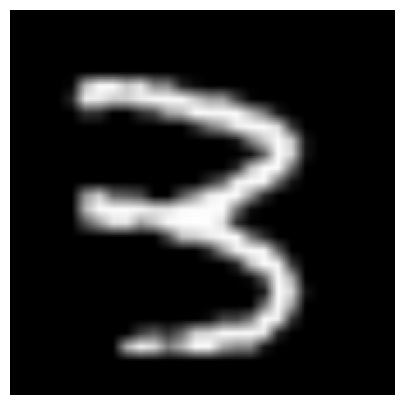

In [46]:
x, y = il.one_batch()
print(x.shape, y.shape)
x[0].show()

In [61]:
model = nn.Sequential(
    ConvLayer(ni=3, nf=64, stride=2, ks=7, padding=3),
    MaxPool(ks=3, stride=2, padding=1),
    Con
)

learn = Learner(il, model, loss_func=F.cross_entropy, metrics=accuracy)
print(learn.summary())

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       True      
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
____________________________________________________________________________

Total params: 9,536
Total trainable params: 9,536
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7fac5ee7a680>
Loss function: <function cross_entropy at 0x7fada069d750>

Callbacks:
  - TrainEvalCallback
  - CastToTensor
  - Recorder
  - ProgressCallback


In [57]:
# path = untar_data(URLs.MNIST)
# print(path)
# def is_cat(x): return x[0].isupper()

# dls = ImageDataLoaders.from_name_func(
#     path, get_image_files(path), valid_pct=0.2, seed=42,
#     label_func=is_cat, item_tfms=Resize(224))

learn = vision_learner(il, resnet18, metrics=error_rate)
print(learn.summary())

Sequential (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                      